In [2]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.distributions as dist

In [23]:
class GR4J(nn.Module):

    def __init__(self, s_init=0, r_init=0):
        super(GR4J, self).__init__()
        self.s_init = s_init
        self.r_init = r_init
        self.x1 = torch.tensor(109.37118080390698)#dist.uniform.Uniform(100, 1200).sample()
        self.h1 = nn.Linear(4, 32)
        self.h2 = nn.Linear(32, 16)
        self.h3 = nn.Linear(16, 4)
        self.o = nn.Linear(4, 1)

    
    def forward(self, prec, etp):
        
        # Number of simulation timesteps
        num_timesteps = len(prec)
        
        # Unpack the model parameters
        x1 = self.x1

        # Production Storage
        p_n = torch.relu(prec - etp)
        e_n = torch.relu(etp - prec)

        # Production store
        num_timesteps = len(prec)
        p_s = torch.zeros(num_timesteps)
        e_s = torch.zeros(num_timesteps)
        perc = torch.zeros(num_timesteps)
        s_store = torch.zeros(num_timesteps + 1)
        s_store[0] = self.s_init * x1

        for t in range(num_timesteps):
            # calculate fraction of netto precipitation that fills
            #  production store (eq. 3)
            p_s[t] = ((x1 * (1 - (s_store[t-1] / x1)**2) * torch.tanh(p_n[t]/x1)) /
                (1 + s_store[t-1] / x1 * torch.tanh(p_n[t] / x1)))

            # from the production store (eq. 4)
            e_s[t] = ((s_store[t-1] * (2 - s_store[t-1]/x1) * torch.tanh(e_n[t]/x1)) 
                / (1 + (1 - s_store[t-1] / x1) * torch.tanh(e_n[t] / x1)))

            s_store[t] = s_store[t - 1] + p_s[t] - e_s[t]

            # calculate percolation from actual storage level
            perc[t] = s_store[t] * (1 - (1 + (4/9 * s_store[t] / x1)**4)**(-0.25))
            
            # final update of the production store for this timestep
            s_store[t] = s_store[t] - perc[t]

        # Expand dim
        p_n = p_n[:, None]
        e_n = e_n[:, None]
        p_s = p_s[:, None] 
        perc = perc[:, None]
        
        # Concatenate
        inp = torch.concat([p_n, e_n, p_s, perc], dim=1)

        # ANN
        out = self.h1(inp.float())
        out = torch.relu(self.h3(self.h2(out)))
        out = torch.relu(self.o(out)).flatten()

        return out

In [24]:
data_location = os.path.join('/data')

In [25]:
# Calibration period
calib_start_year = 1990
calib_end_year = 2000

# Holdout period
holdout_start_year = 2000
holdout_end_year = 2005

In [26]:
# Load the data
maulescreek_rain_et = pd.read_csv(
    os.path.join(
        data_location,
        'SILO(-30.5,150.1)',
        'FAO56_Penman_Monteith_1989.csv'
    )
)
maulescreek_streamflow = pd.read_csv(
    os.path.join(
        data_location,
        'water_level',
        'bom_gauge_daily_mean_419051.csv'
    )
)

# fix dates 
maulescreek_rain_et['Date'] = pd.to_datetime(maulescreek_rain_et['Date2'],format="%d-%m-%Y")
maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Timestamp'],utc=True, format='%Y-%m-%d')
maulescreek_streamflow['Date'] = maulescreek_streamflow['Date'].dt.date
maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Date'])

In [27]:
# 
merged_data = pd.merge(
    maulescreek_rain_et,
    maulescreek_streamflow,
    left_on='Date',
    right_on='Date'
)

# Slicing the data into calibration and holdout
calibration_data = merged_data.loc[((merged_data['Date']).dt.year >= calib_start_year) & ((merged_data['Date']).dt.year < calib_end_year)].reset_index(drop=True)

holdout_data = merged_data.loc[((merged_data['Date']).dt.year >= holdout_start_year) & ((merged_data['Date']).dt.year < holdout_end_year)].reset_index(drop=True)

In [28]:
# Tune GR4J parameters
prcp_calib = torch.from_numpy(calibration_data.loc[:, 'Rain'].values.astype('float32'))
et_calib = torch.from_numpy(calibration_data.loc[:, 'FAO56'].values.astype('float32'))
flow_calib = torch.from_numpy(calibration_data.loc[:, 'Value'].values.astype('float32'))
date_calib = calibration_data.loc[:, 'Date'].values


In [29]:
def nse(targets, predictions):
    return 1-(torch.sum((targets-predictions)**2)/torch.sum((targets-torch.mean(targets))**2))

def nnse(targets, predictions):
    return 1/(2 - nse(targets, predictions))

def evaluate(model, dates, et, prcp, flow):
    
    flow_pred = model(prcp, et)

    nse_score = nse(flow, flow_pred)
    nnse_score = nnse(flow, flow_pred)

    print(f"NSE: {nse_score:.3f}")
    print(f"Normalized NSE: {nnse_score:.3f}")

    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(dates, flow.numpy(), label='obs')
    ax.plot(dates, flow_pred.detach().numpy(), label='pred')

    ax.set_xlabel('Date')
    ax.set_ylabel('Flow')

    plt.legend()

In [30]:
model = GR4J()
opt = torch.optim.Adam(model.parameters(), lr=0.01)
result = model(prec=prcp_calib, etp=et_calib)
result

tensor([0.1637, 0.1645, 0.1710,  ..., 0.1212, 0.1578, 0.1584],
       grad_fn=<ReshapeAliasBackward0>)

In [31]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

h1.weight tensor([[ 0.3497, -0.3575, -0.0468, -0.1806],
        [ 0.2596, -0.3858, -0.2107, -0.3020],
        [-0.0381, -0.3242, -0.1967,  0.2815],
        [ 0.1417,  0.0373,  0.0160, -0.4762],
        [-0.4400, -0.0326,  0.3677,  0.4162],
        [-0.4908, -0.0757,  0.3668, -0.2316],
        [ 0.2248, -0.4020,  0.3424,  0.0405],
        [ 0.1023,  0.4995, -0.4151,  0.3867],
        [ 0.0301,  0.1017, -0.4689, -0.1184],
        [ 0.4572, -0.3763, -0.4672, -0.0469],
        [-0.2426,  0.0621, -0.2941,  0.3820],
        [-0.1878, -0.4443, -0.0613,  0.4106],
        [-0.4714,  0.2558,  0.3280,  0.0654],
        [-0.3102,  0.1215,  0.2945,  0.4837],
        [ 0.2905,  0.1856,  0.0908, -0.3555],
        [ 0.1637,  0.2068, -0.0831, -0.1913],
        [-0.4982, -0.2613, -0.3628,  0.4104],
        [ 0.0279,  0.0745,  0.1594,  0.0233],
        [-0.2960,  0.3808, -0.0728,  0.0048],
        [-0.0605, -0.4348, -0.0517,  0.1495],
        [-0.1316, -0.3724,  0.1022, -0.2716],
        [ 0.4543, -0.204

In [32]:
N = 200

for epoch in range(N):

    opt.zero_grad()

    pred_flow = model(prcp_calib, et_calib)

    loss = torch.nn.functional.mse_loss(flow_calib, pred_flow)

    loss.backward()

    opt.step()

    print(f"Epoch {epoch+1} loss: {loss.detach().numpy():.4f}")

Epoch 1 loss: 35.2656
Epoch 2 loss: 34.9340
Epoch 3 loss: 34.5780
Epoch 4 loss: 33.8178
Epoch 5 loss: 33.2311
Epoch 6 loss: 33.2291
Epoch 7 loss: 33.4465
Epoch 8 loss: 33.2273
Epoch 9 loss: 32.9296
Epoch 10 loss: 32.6777
Epoch 11 loss: 32.5472
Epoch 12 loss: 32.4597
Epoch 13 loss: 32.3503
Epoch 14 loss: 32.2046
Epoch 15 loss: 32.0409
Epoch 16 loss: 31.8836
Epoch 17 loss: 31.7331
Epoch 18 loss: 31.5629
Epoch 19 loss: 31.3636
Epoch 20 loss: 31.1818
Epoch 21 loss: 31.0021
Epoch 22 loss: 30.8056
Epoch 23 loss: 30.5946
Epoch 24 loss: 30.3936
Epoch 25 loss: 30.2229
Epoch 26 loss: 30.0818
Epoch 27 loss: 29.9572
Epoch 28 loss: 29.8964
Epoch 29 loss: 29.8635
Epoch 30 loss: 29.8660
Epoch 31 loss: 29.8992
Epoch 32 loss: 29.9389
Epoch 33 loss: 29.9698
Epoch 34 loss: 29.9616
Epoch 35 loss: 29.9876
Epoch 36 loss: 29.9838
Epoch 37 loss: 29.9550
Epoch 38 loss: 29.9466
Epoch 39 loss: 29.9254
Epoch 40 loss: 29.8767
Epoch 41 loss: 29.8508
Epoch 42 loss: 29.8224
Epoch 43 loss: 29.7749
Epoch 44 loss: 29.74

In [33]:
flow_calib, pred_flow

(tensor([0.1470, 0.1440, 0.1410,  ..., 0.0730, 0.0740, 0.0810]),
 tensor([0.1266, 0.1266, 0.1266,  ..., 0.1266, 0.1266, 0.1266],
        grad_fn=<ReshapeAliasBackward0>))

NSE: 0.188
Normalized NSE: 0.552


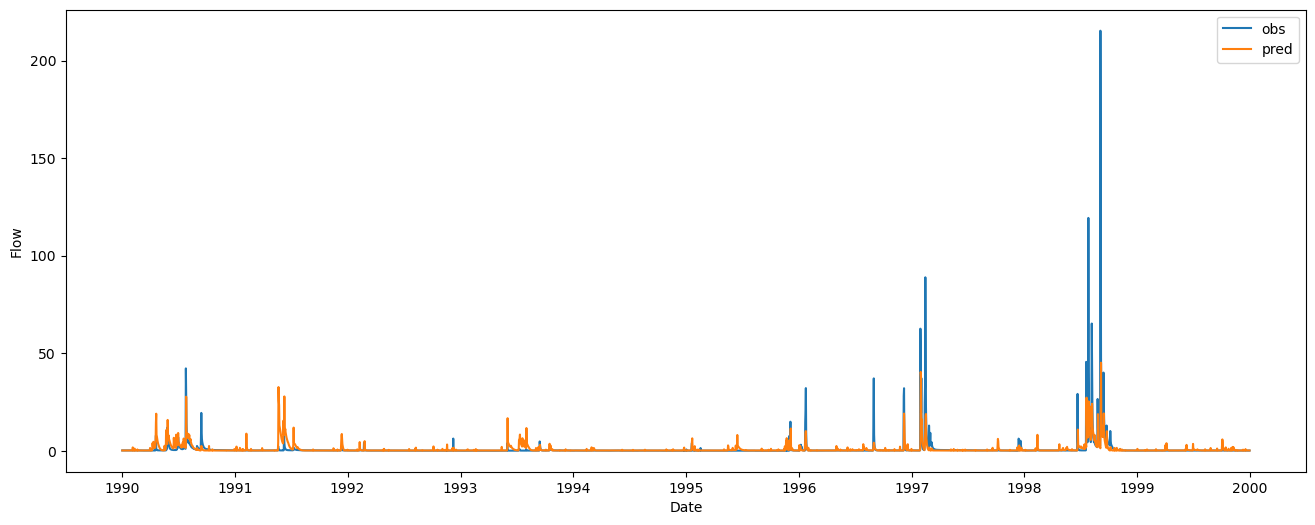

In [34]:
evaluate(model, date_calib,  et_calib, prcp_calib, flow_calib)

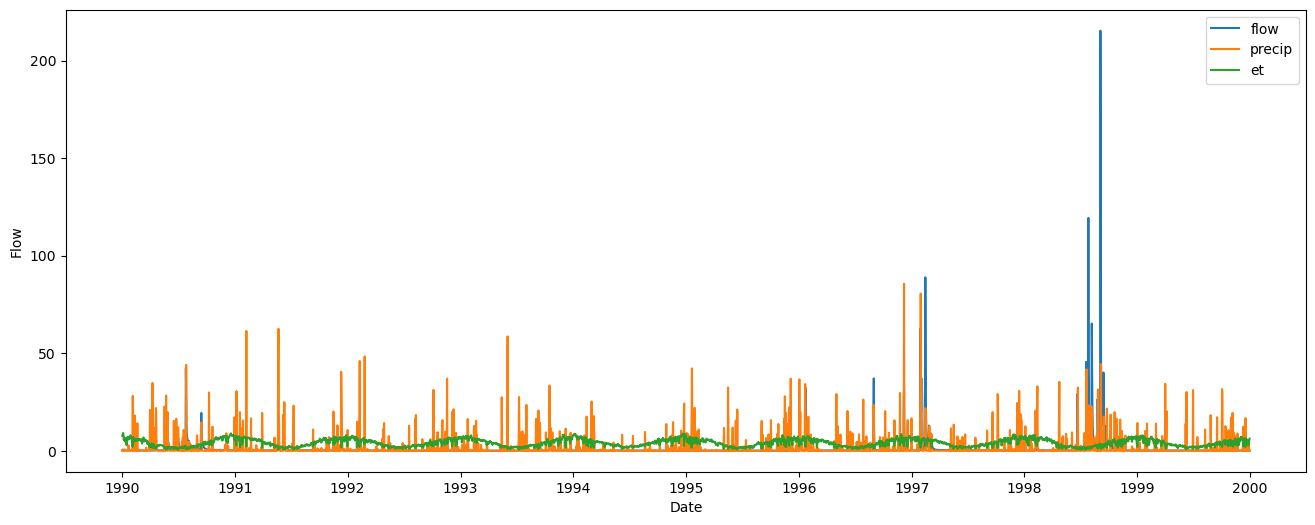

In [35]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(date_calib, flow_calib.numpy(), label='flow')
ax.plot(date_calib, prcp_calib.numpy(), label='precip')
ax.plot(date_calib, et_calib.numpy(), label='et')

ax.set_xlabel('Date')
ax.set_ylabel('Flow')

plt.legend()